In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-12-30 02:44:17.985603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 02:44:18.121671: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-30 02:44:18.128226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 02:44:18.128240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
import scanpy as sc

babel_dir = '../data/babel_data/DM_rep4/'
train = sc.read_h5ad(babel_dir + 'train_rna.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_rna.h5ad').X.toarray()
data1 = np.concatenate([train, valid], axis=0)
fnames1 = np.array(v)

train = sc.read_h5ad(babel_dir + 'train_atac.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_atac.h5ad').X.toarray()
data2 = np.concatenate([train, valid], axis=0)
fnames2 = np.array(v)

split = train.shape[0]

/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dataset_name = 'DM_rep4'
dataset_color = 'black'
modality_names = ['RNA', 'ATAC']

# data1 = PCA(n_components=32).fit_transform(data1)
# data2 = PCA(n_components=32).fit_transform(data2)
# fnames1 = fnames2 = None

type1 = np.array(len(data1) * ['Cell Type 0'])
type2 = np.array(len(data2) * ['Cell Type 0'])

# Sampling
# sample_num = 500
# data_col_idx = np.random.choice(range(split), sample_num, replace=False)
# data1, data2, type1, type2 = (x[list(data_col_idx) + list(range(split, len(data1)))] for x in (data1, data2, type1, type2))
# split = sample_num

# Labels
labels = [type1, type2]
features = [np.array(fnames1), np.array(fnames2)]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

In [6]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# # Train-Test Imputation
train_size = split
train_idx = np.array(range(split))
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

In [7]:
reduced_dim = 32
kwargs_imp = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}

# JAMIE

In [8]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model './saved_models/jm_im---DM_rep4---4301-34861---4301-85596.h5'


# Comparison Methods

In [9]:
# Imputation
if True:
    imputation_name = 'Babel'
    bdata1 = sc.read_h5ad(babel_dir + 'atac_rna_test_preds.h5ad').X.toarray()
    bdata2 = sc.read_h5ad(babel_dir + 'rna_atac_test_preds.h5ad').X.toarray()
    nn_imputed = [bdata1, bdata2]
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
# imputed_data_full = [jm_imputed, nn_imputed][::-1]
# imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_data = [[d[test_idx] for d in jm_imputed], nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [10]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

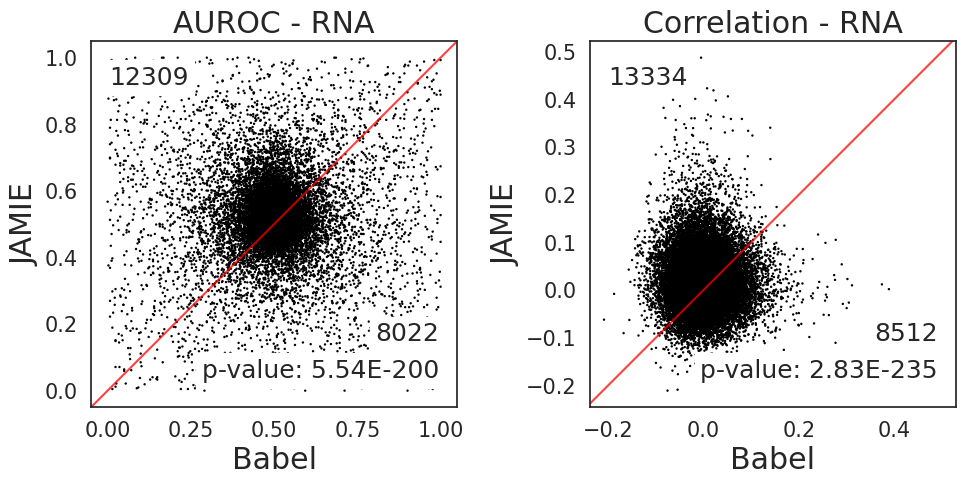

In [11]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300)

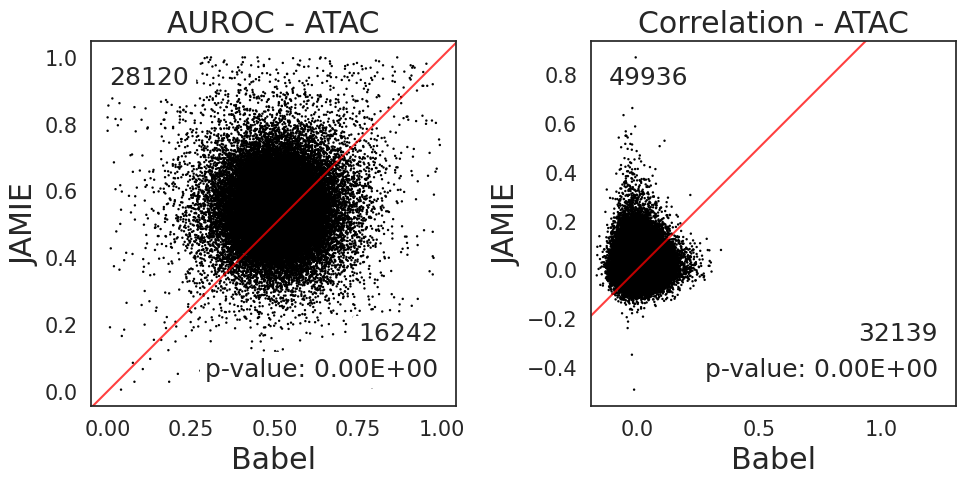

In [12]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300)

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PVT1: 0.4778376187547247
APCDD1: 0.6561669585444838


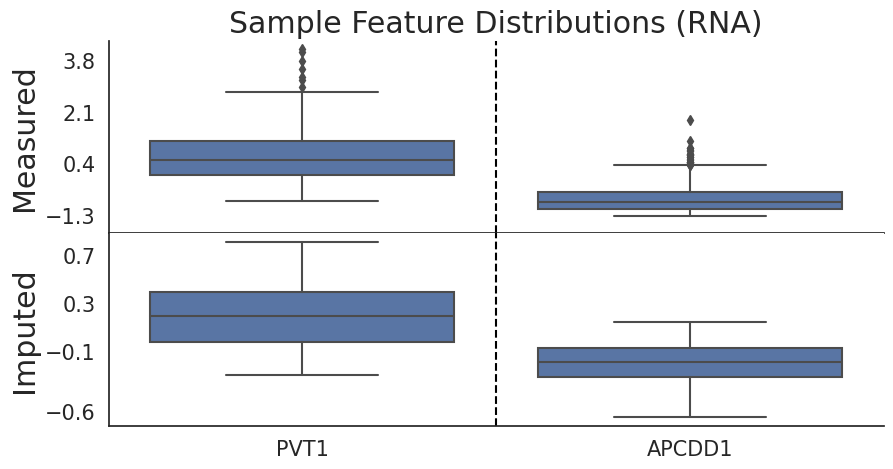

In [13]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300)

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


chr20:63449553-63450619: 0.7262829367629149
chr6:16064719-16065052: 0.7031172406403514


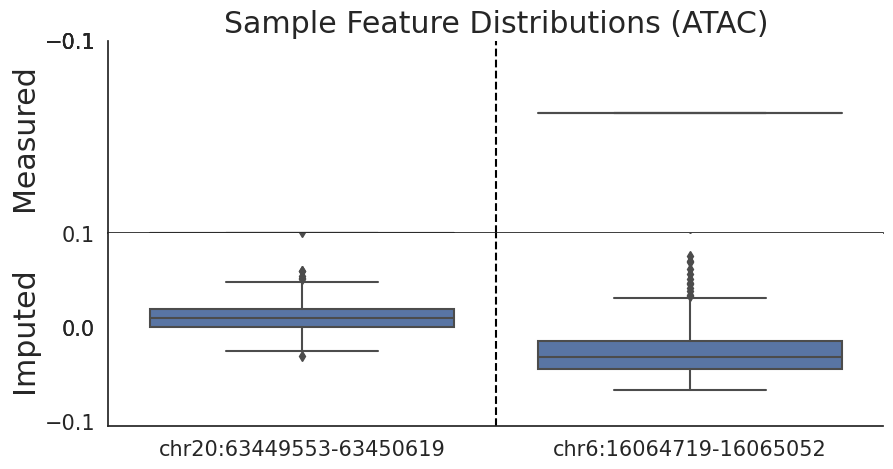

In [14]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300)

# Explanation

In [15]:
mod0, mod1 = 1, 0
current_jm = jm_im
analysis_base = f'{output_folder}JAMIE---{size_str}---'
analysis_str = analysis_base + 'sorted_genes'

In [16]:
# LTA
# target_name = 'LTA'
# Ly = current_jm.transform_one(dataset[mod1], mod1)
# function = lambda x, y: current_jm.test_LabelTA([current_jm.transform_one(x, mod0), Ly], labels)
# true = None

# Imputation
target = sort_by_interest([dataset[mod1], current_jm.modal_predict(dataset[mod0], mod0)], limit=20, remove_outliers=True)[1][1]
target_name = features[mod1][target] + '\nCorrelation'
function = lambda x: current_jm.modal_predict(x, mod0)[:, target]
true = dataset[mod1][:, target]
from scipy.stats import pearsonr
perf_function = lambda x, y: pearsonr(x, y)[0]

# testing_idx = np.array(range(dataset[mod0].shape[1]))
testing_idx = sort_by_interest([dataset[mod0], dataset[mod0]], limit=1000, remove_outliers=False)[1]
# testing_idx = np.random.choice(dataset[mod0].shape[0], 1000, replace=False)
# scan = None
scan = 100

if not os.path.exists(analysis_str):
    baseline, performance, new_idx = evaluate_impact(function, perf_function, dataset[mod0], true, features[mod0], idx=testing_idx, scan=scan)
    argsort = np.argsort(performance)
    sorted_idx = new_idx[argsort]
    sorted_names = features[mod0][sorted_idx]
    sorted_names = np.array([s.replace(' ', '_') for s in sorted_names])
    sorted_perf = performance[argsort]
    
    file_contents = np.concatenate([sorted_idx.reshape((-1, 1)), sorted_names.reshape((-1, 1)), sorted_perf.reshape((-1, 1))], axis=1)
    file_contents_str = '\n'.join([' '.join([str(s) for s in r]) for r in file_contents]) + '\n'
    with open(analysis_str, 'w') as f:
        f.write(file_contents_str)
else:
    baseline = perf_function(function(dataset[mod0]), true)
    sorted_idx = []
    sorted_names = []
    sorted_perf = []
    with open(analysis_str, 'r') as f:
        for line in f:
            idx, names, perf = line[:-1].split(' ')
            sorted_idx.append(int(idx))
            sorted_names.append(str(names))
            sorted_perf.append(float(perf))
    sorted_idx, sorted_names, sorted_perf = np.array(sorted_idx), np.array(sorted_names), np.array(sorted_perf)
    performance = sorted_perf

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [17]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = sorted_names[:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target RNA Feature: DENND1B
Correlation
https://www.genecards.org/cgi-bin/carddisp.pl?gene=DENND1B
Correlation
Important ATAC Features: chr1:163361107-163362488, chr1:165348280-165349375, chr1:163001448-163002289, chr1:162790182-162790829, chr1:153617198-153618109, chr1:151157311-151158247, chr1:155093699-155094854, chr1:158177472-158178246, chr1:162155818-162157102, chr1:158087230-158087962, chr1:150979172-150979976, chr1:149102895-149103856, chr1:150784031-150788571, chr1:161906500-161907235, chr1:157155293-157156634, chr1:150165731-150166561, chr1:148355883-148356952, chr1:121097062-121098158, chr1:171718211-171719755, chr1:113887410-113888303
0.92560: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr1:163361107-163362488
0.92560: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr1:165348280-165349375
0.92560: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr1:163001448-163002289
0.92560: https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr1:162790182-162790829
0.925

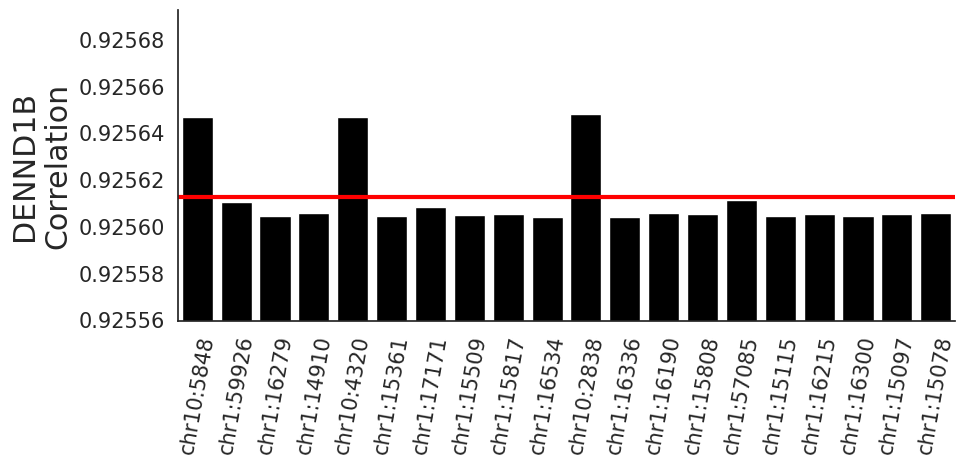

In [18]:
plt.figure(figsize=(10, 5))
plot_impact(sorted_perf, sorted_names, baseline, max_features=20, color=dataset_color, ylabel=target_name)
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Analysis.png', dpi=300, bbox_inches='tight')